In [17]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

In [2]:
# Definir parámetros
api_key = "CG-FmA9mmd1SDu5Nj182bpbsnMD"
crypto_id = "bitcoin"
currency = "mxn"
days = "365"

# Solicitud para obtener datos históricos
url = f"https://api.coingecko.com/api/v3/coins/{crypto_id}/market_chart?x_cg_demo_api_key={api_key}&vs_currency={currency}&days={days}"

# Hacer solicitud
response = requests.get(url, verify=False)
response.raise_for_status()
data = response.json()

c:\Users\seelro06\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.coingecko.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
prices = data["prices"]
df = pd.DataFrame(prices, columns=["timestamp", "price"])
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")
df.set_index("timestamp", inplace=True)

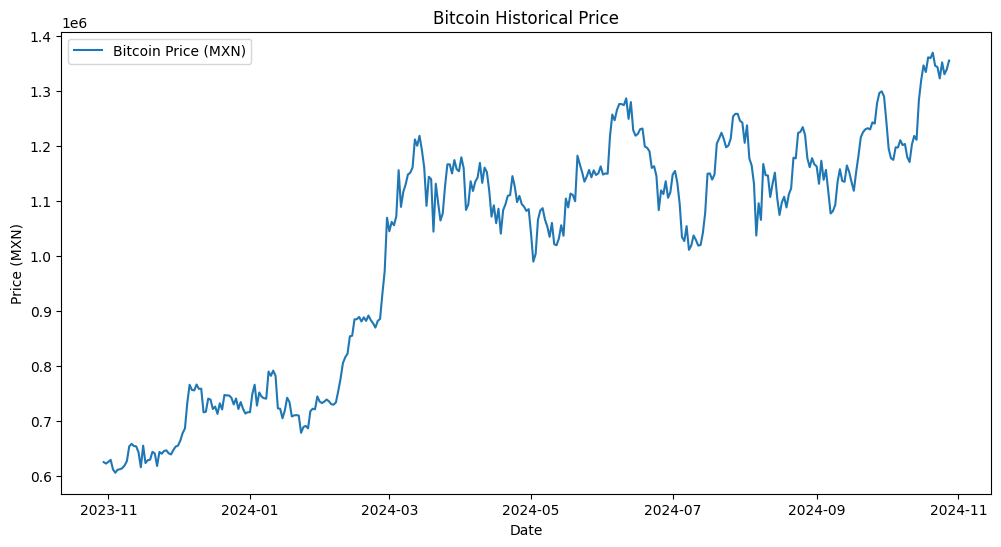

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["price"], label=f"{crypto_id.capitalize()} Price ({currency.upper()})")
plt.title(f"{crypto_id.capitalize()} Historical Price")
plt.xlabel("Date")
plt.ylabel(f"Price ({currency.upper()})")
plt.legend()
plt.show()


In [6]:
# Parámetros de la serie de tiempo
sequence_length = 50

# Crear las secuencias de entrada y salida
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i : (i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

price_data = df["price"].values
X, y = create_sequences(price_data, sequence_length)

In [16]:
# Escalar los datos
scaler = MinMaxScaler()
y = scaler.fit_transform(y.reshape(-1, 1))

In [18]:
# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Definir el modelo LSTM
model = Sequential([
    Input(shape=(sequence_length, 1)),
    LSTM(50, activation="relu"),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")

In [20]:
# Entrenar el modelo
# X = X.reshape((X.shape[0], X.shape[1], 1))
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 639305920.0000
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 425329056.0000
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 275804160.0000
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 189357440.0000
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 124536944.0000
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 87618184.0000
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 60687012.0000
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 41117612.0000
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 29052076.0000
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 19803378.0000
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 13177839.0000
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8470756.0000
Epoch 13/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5098315.5000
Epoch 14/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3014441.2500
Epo

In [21]:
# Evaluar el modelo
loss = model.evaluate(X_test, y_test)
print(f"Loss en el conjunto de prueba: {loss}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1739.2552  
Loss en el conjunto de prueba: 1685.231689453125
